# Outline
    preprocessing
        impute base on 2 hour avg
        shift 1 - 12 columns
        feature engineering
    trainning
        1 - 6





In [10]:
import pandas as pd

file_path = 'data/data.csv'
data = pd.read_csv(file_path, index_col=0)

## data visuallization

In [11]:
data.head(5)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


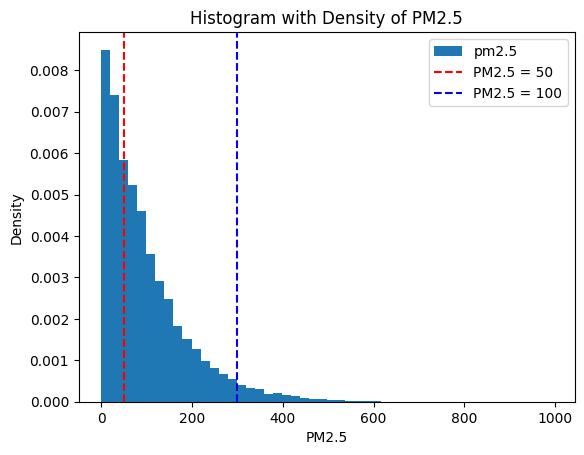

In [12]:
import matplotlib.pyplot as plt

# Adjusted the number of bins to be finer (thinner) by increasing the number
data['pm2.5'].plot(kind='hist', bins=50, density=True, title='Histogram with Density of PM2.5')
plt.xlabel('PM2.5')
plt.ylabel('Density')
plt.axvline(x=50, color='r', linestyle='--', label='PM2.5 = 50')
plt.axvline(x=300, color='b', linestyle='--', label='PM2.5 = 100')
plt.legend()
plt.show()

In [13]:
# Calculate the percentage of pm2.5 values greater than or equal to 50
pm25_gte_50 = (data['pm2.5'] >= 50).mean() * 100
print(f"Percentage of PM2.5 values >= 50: {pm25_gte_50:.2f}%")

# Calculate the percentage of pm2.5 values greater than or equal to 100
pm25_gte_100 = (data['pm2.5'] >= 300).mean() * 100
print(f"Percentage of PM2.5 values >= 300: {pm25_gte_100:.2f}%")

Percentage of PM2.5 values >= 50: 59.49%
Percentage of PM2.5 values >= 300: 4.05%


In [14]:
daily_hour_counts = data.groupby(['year', 'month', 'day']).size()
missing_hours = daily_hour_counts[daily_hour_counts != 24]
missing_hours
# no missing hours

Series([], dtype: int64)

## preprocessing

In [15]:
data['pm2.5_next_hour'] = data['pm2.5'].shift(-1)
data['pm2.5_above_50_next'] = data['pm2.5_next_hour'] >= 50

# Drop rows where pm2.5_above_50_next is NaN (equivalent to empty in this context)
data.dropna(subset=['pm2.5_above_50_next'], inplace=True)

# Convert boolean to binary (0 and 1)
data['pm2.5_above_50_next'] = data['pm2.5_above_50_next'].astype(int)

# One-hot encode the 'cbwd' column
data = pd.get_dummies(data, columns=['cbwd'])

data.drop(columns='pm2.5_next_hour', inplace=True)

# dropping year
data.drop(columns='year', inplace=True)

## training

Test set Mean Squared Error: 0.13


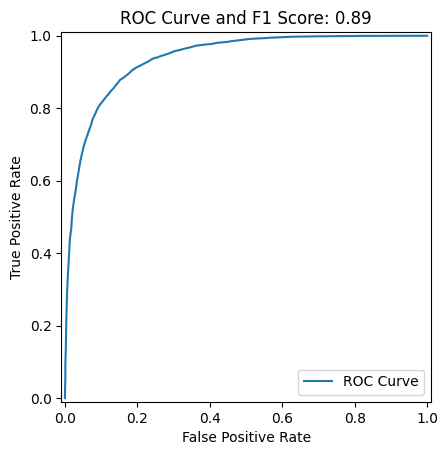

In [16]:
# training simple rf no cv
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, f1_score, RocCurveDisplay, mean_squared_error

# Prepare the data
X = data.drop(columns=['pm2.5', 'pm2.5_above_50_next'])
y = data['pm2.5_above_50_next']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict probabilities
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(label="ROC Curve")

# Compute F1 score
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)

# Compute and print MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Test set Mean Squared Error: {mse:.2f}')

plt.title(f'ROC Curve and F1 Score: {f1:.2f}')
plt.show()

Test set Mean Squared Error (Naive Bayes): 0.30


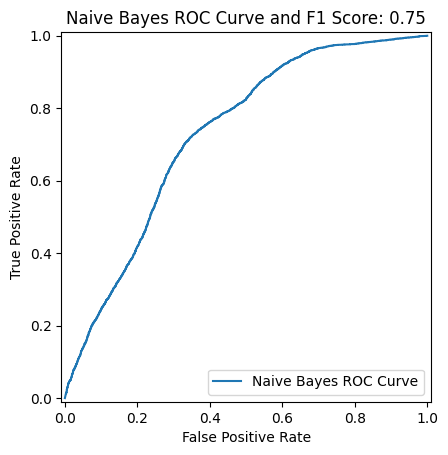

In [17]:
# baseline model

from sklearn.naive_bayes import GaussianNB

# Create a pipeline with Gaussian Naive Bayes
naive_bayes_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

# Train the Gaussian Naive Bayes model
naive_bayes_pipeline.fit(X_train, y_train)

# Predict probabilities with Gaussian Naive Bayes
y_scores_naive_bayes = naive_bayes_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve for Gaussian Naive Bayes
fpr_naive_bayes, tpr_naive_bayes, _ = roc_curve(y_test, y_scores_naive_bayes)
roc_display_naive_bayes = RocCurveDisplay(fpr=fpr_naive_bayes, tpr=tpr_naive_bayes)
roc_display_naive_bayes.plot(label="Naive Bayes ROC Curve")

# Compute F1 score for Gaussian Naive Bayes
y_pred_naive_bayes = naive_bayes_pipeline.predict(X_test)
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes)

# Compute and print MSE for Gaussian Naive Bayes
mse_naive_bayes = mean_squared_error(y_test, y_pred_naive_bayes)
print(f'Test set Mean Squared Error (Naive Bayes): {mse_naive_bayes:.2f}')

plt.title(f'Naive Bayes ROC Curve and F1 Score: {f1_naive_bayes:.2f}')
plt.show()